## Clip Vertical Displacement Geotiff

#### Needed: Single merged geotiff from alaska satellite facility (see Merge_ASF_Scenes code). Due to the time it takes to run code, it  helps to manually clip the broad area in arcgis or a similar program.

#### Result: Clipped vertical displacement raster with exact same dimensions as vegetation (and hopefully soon JABLTCX) data. This will probably need further reprojecting but the spatial extent and shape should be identical.

In [1]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import earthpy.plot as ep
import rasterio as rio
import rioxarray as rxr
from shapely.geometry import box
import scipy.stats as stats
import skimage.transform as st
from osgeo import gdal

/Users/tylerlogie/opt/anaconda3/envs/geostats_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# most important thing is that the vegetation and vertical displacement data are correlated. once volume change is
# properly integrated we can run a similar reprojection for that

# first, import the two files that are being reprojected together
vert_disp = rxr.open_rasterio(
    "../RawData/partial_clipped_10_08_to_11_25_combined.tiff",
    masked=True
)
veg_before = rxr.open_rasterio(
    "../../Vegetation/RawData/NDVI image Before.tif",
    masked=True
)
veg_after = rxr.open_rasterio(
    "../../Vegetation/RawData/NDVI image After.tif",
    masked=True
)

veg = veg_after - veg_before

In [3]:
# the crs are likely different for data from different sites. using reproject_match we can get them into the same scheme
print("Original Vertical Displacement CRS:", vert_disp.rio.crs)
print("Vegetation CRS:", veg.rio.crs)

vert_disp_new = vert_disp.rio.reproject_match(veg)
# the new vertical displacement crs should match the vegetation crs. if not, something has gone wrong.
# note: this can take a second
print("Reprojected Vegetation Displacement CRS:", vert_disp_new.rio.crs)

Original Vertical Displacement CRS: EPSG:32618
Vegetation CRS: EPSG:4326
Reprojected Vegetation Displacement CRS: EPSG:4326


In [4]:
# manually input the coordinates of outer banks kml file. this will be used to form a polygon to clip the vertical
# displacement raster.
geoms = [{'type': 'Polygon', 'coordinates': [[(-75.5649, 35.4359),(-75.5774, 35.3337),(-75.5889, 35.1984),
                                              (-75.52, 35.1725),(-75.5023, 35.2456),(-75.4524, 35.414),
                                              (-75.433, 35.5557),(-75.4615, 35.7352),(-75.5146, 35.8125),
                                              (-75.5959, 35.9524),(-75.6708, 36.0845),(-75.7566, 36.2564),
                                              (-75.7946, 36.3574),(-75.837, 36.4861),(-75.8554, 36.5716),
                                              (-75.8714, 36.6285),(-75.8855, 36.6576),(-75.9126, 36.7112),
                                              (-75.9443, 36.8002),(-75.9537, 36.8366),(-75.9686, 36.8867),
                                              (-75.9868, 36.9362),(-76.0129, 36.9526),(-76.057, 36.9565),
                                              (-76.006, 36.825),(-75.9527, 36.648),(-75.904, 36.5225),
                                              (-75.8666, 36.3768),(-75.7944, 36.2111),(-75.7309, 36.0382),
                                              (-75.5649, 35.4359)]]}]
# clip the data using above polygon
clipped = vert_disp_new.rio.clip(geoms)

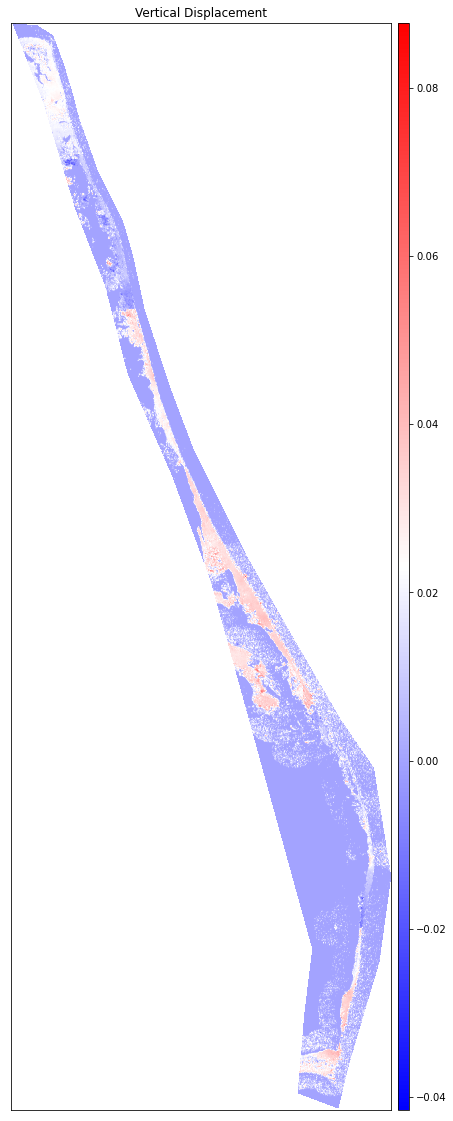

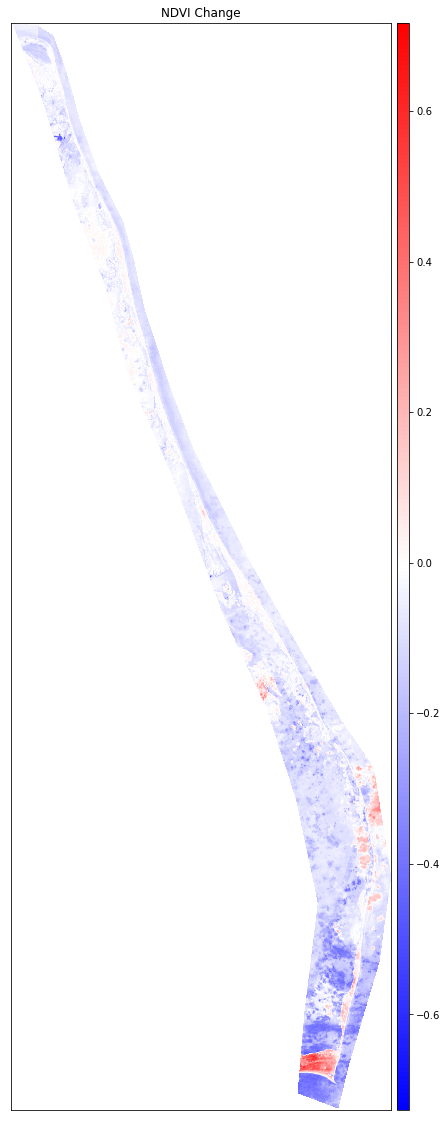

In [5]:
# the area of this plot should look like the area of the vegetation raster
# this can take quite a while, especially with geotiffs that aren't already cut down some
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,30))
ep.plot_bands(clipped, 
         title="Vertical Displacement",    
         cmap="bwr",
         figsize = (10,20)
        )

ep.plot_bands(veg,
         title="NDVI Change",
         cmap = "bwr",
         figsize = (10,20)
        )
plt.show()

In [6]:
print(type(clipped))
print(type(veg))
print(clipped)
print(veg)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<xarray.DataArray (band: 1, y: 19859, x: 6947)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 36.96 36.96 36.96 36.96 ... 35.17 35.17 35.17 35.17
  * x            (x) float64 -76.06 -76.06 -76.06 ... -75.43 -75.43 -75.43
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0
<xarray.DataArray (band: 1, y: 19860, x: 6947)>
array([[[0.05845633, 0.08341625, 0.11157522, ...,        nan,
                nan,        nan],
        [0.09978211, 0.08369619, 0.07976189, ...,        nan,
                nan,        nan

### Downsampling
These datasets are extremely large at the scale that was given by reproject_match. Next task is to downsample the data to a 80x80 m resolution

In [7]:
# now export the created clipped geotiff
# the metadata is already saved to the geotiff
# double check that the resolutions are the same
#clipped.rio.resolution = (80,80)
#veg.rio.resolution = (80,80)
print(clipped.rio.resolution())
print(veg.rio.resolution())
print(os.getcwd())

clipped.rio.to_raster("../ProcessedData/complete_clipped_2018_10_08_to_11_25_combined.tif", driver="GTiff")


#clipped_raster = clipped.rio.to_raster("../ProcessedData/complete_clipped_2018_10_08_to_11_25_combined.tif")
# save file as geotiff
#out_file = "../ProcessedData/complete_clipped_2018_10_08_to_11_25_combined.tif"
# if there is already a file with this name, delete and resave the new file
#if os.path.isfile(out_file):
#    os.remove(out_file)
# write the geotiff file with relavent metadata using rio.open
#with rio.open(out_file, "w", driver=clipped.driver) as dest:
#        dest.write(clipped)

(8.983152841195131e-05, -8.9831528411952e-05)
(8.983152841195215e-05, -8.983152841195215e-05)
/Users/tylerlogie/Documents/School_Work_Fall_2021/EnvDatSci/FinalProject/Coastal-Bathymetry-Group/VerticalDisplacement/Code


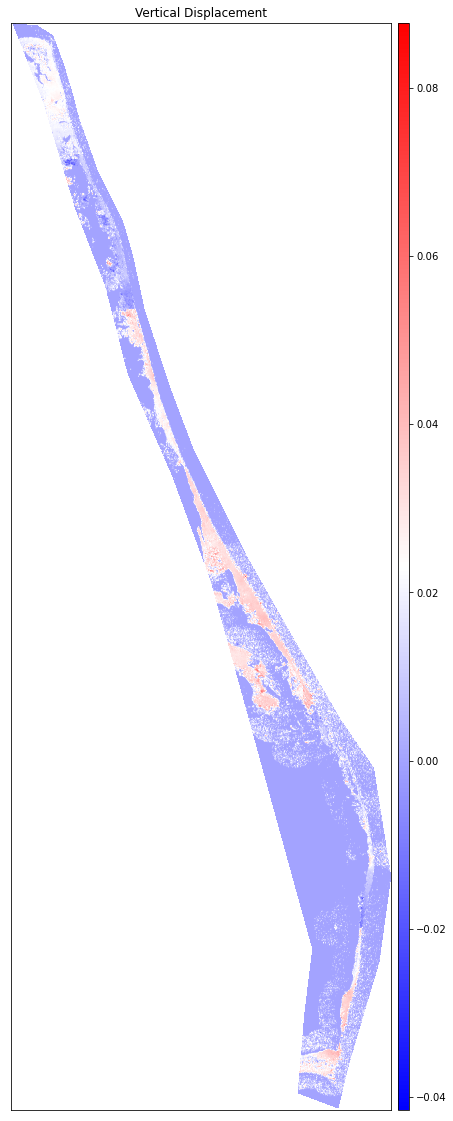

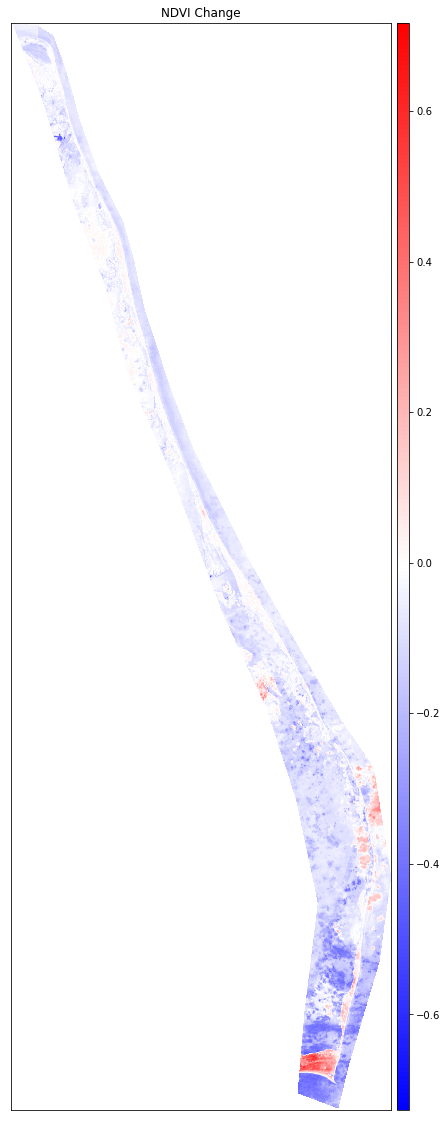

In [8]:
ep.plot_bands(clipped, 
         title="Vertical Displacement",    
         cmap="bwr",
         figsize = (10,20)
        )

ep.plot_bands(veg,
         title="NDVI Change",
         cmap = "bwr",
         figsize = (10,20)
        )
plt.show()

### Current Code:
The model will not run if there are any nan values. The simple solution would be to just drop nan or 0 values (since the zeros would throw off the model). But in order to keep the arrays the same size, if we drop from one array, we need to drop the value at the same location from both. The ugly implementation is to check through each row, and then each column within the row, and if that cell in array X OR array Y is nan or 0, drop from both. This is extremely computationally inefficient.

The next iteration of this preparation will be to flatten the arrays, add them to a pandas dataframe, and drop any rows with nan values. This table is export as a csv, and will be used in a second file with the main model and analysis code.

In [9]:
# example linear regression comparing values from the clipped vertical displacement data and the vegetation data
# the [0] is because it creates a 3d array that is more difficult to model with, but the outermost shell of the array
# only has one value containing all data points in a 2d array.

# for whatever reason, the vegetation datasets have one extra pixel of height over the vertical displacement datasets.
# in order to get these the same size, we dropped the last row of the veg data, which only had 2 non-nan values
X, Y1, Y2, Y3 = clipped.values[0],veg_before.values[0][:-1],veg_after.values[0][:-1],veg.values[0][:-1]
print(type(X),type(Y1), type(Y2), type(Y3))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [10]:
flat_X = X.flatten().reshape(-1,1)
flat_Y1 = Y1.flatten().reshape(-1,1)
flat_Y2 = Y2.flatten().reshape(-1,1)
flat_Y3 = Y2.flatten().reshape(-1,1)
print(flat_X.shape, flat_Y1.shape, flat_Y2.shape, flat_Y3.shape)

(137960473, 1) (137960473, 1) (137960473, 1) (137960473, 1)


In [11]:
# this is a much faster way to do it than the code below, but we're having trouble figuring out how to get them the 
# same size before going through the necessary processing of nan values

twoD_array = np.concatenate([flat_X, flat_Y1, flat_Y2,flat_Y3], axis=1)
print(twoD_array.shape)
df = pd.DataFrame(twoD_array,columns= ['Vertical Displacement','NDVI Before','NDVI After', 'NDVI Change'])
df = df.dropna(axis = 0, how = 'any')
# somehow NDVI change was reset to NDVI after
df['NDVI Change'] = df['NDVI After'] - df['NDVI Before']
df.head()

(137960473, 4)


,Vertical Displacement,NDVI Before,NDVI After,NDVI Change
0,0.0,-0.382114,-0.323657,0.058456
1,0.0,-0.393075,-0.309659,0.083416
2,0.0,-0.373737,-0.262162,0.111575
3,0.0,-0.388664,-0.268293,0.120371
4,0.0,-0.380165,-0.231746,0.148419


In [12]:
filepath = "../ProcessedData/Model_Ready_Data.csv"
df.to_csv(filepath)

In [13]:
# direct iterative piecewise comparison of points, no longer necessary but kept in case some part is needed
"""
xvals = []
yvals = []
start_time = time.time()

counter = 100
for i in range(len(X)):
    if i % 1000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    for j in range(len(X[0])):
        if ( (np.isnan((X[i][j])) or (X[i][j] == 0) ) or (np.isnan((Y[i][j])) or (Y[i][j] == 0)) ):
            continue
        else:
            xvals.append(X[i][j])
            yvals.append(Y[i][j])"""

'\nxvals = []\nyvals = []\nstart_time = time.time()\n\ncounter = 100\nfor i in range(len(X)):\n    if i % 1000 == 0:\n        print(i)\n        print("--- %s seconds ---" % (time.time() - start_time))\n    for j in range(len(X[0])):\n        if ( (np.isnan((X[i][j])) or (X[i][j] == 0) ) or (np.isnan((Y[i][j])) or (Y[i][j] == 0)) ):\n            continue\n        else:\n            xvals.append(X[i][j])\n            yvals.append(Y[i][j])'

In [14]:
# as a model example, use the ols model from the multicollinearity methods hw
from statsmodels.api import OLS

#standardize data to assist in interpretation of coefficients
x_array = (df["Vertical Displacement"] - np.mean(df["Vertical Displacement"], axis=0)) / np.std(df["Vertical Displacement"], axis=0)

#standardize data to assist in interpretation of coefficients
y_array = (df["NDVI Change"] - np.mean(df["Vertical Displacement"])) / np.std(df["NDVI Change"])

lm = OLS(y_array,x_array)
lm_results = OLS(y_array,x_array).fit().summary()

In [15]:
lm_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            NDVI Change   R-squared (uncentered):                   0.031
Model:                            OLS   Adj. R-squared (uncentered):              0.031
Method:                 Least Squares   F-statistic:                          6.176e+05
Date:                Sun, 21 Nov 2021   Prob (F-statistic):                        0.00
Time:                        23:19:32   Log-Likelihood:                     -3.1447e+07
No. Observations:            19181107   AIC:                                  6.289e+07
Df Residuals:                19181106   BIC:                                  6.289e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Vertical Displacement     0.2057      0.000    786.102      0.000       0.205       0.206
==============================================================================
Omnibus:                  1854102.399   Durbin-Watson:                   0.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14527328.753
Skew:                           0.047   Prob(JB):                         0.00
Kurtosis:                       7.262   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Train a linear regression model using stats.linregress
slope, intercept, r_value, _, _ = stats.linregress(x_array, y_array)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2)

slope: 0.20616825721115614 
intercept: -0.7682557381755688 
r squared: 0.04953937984236329


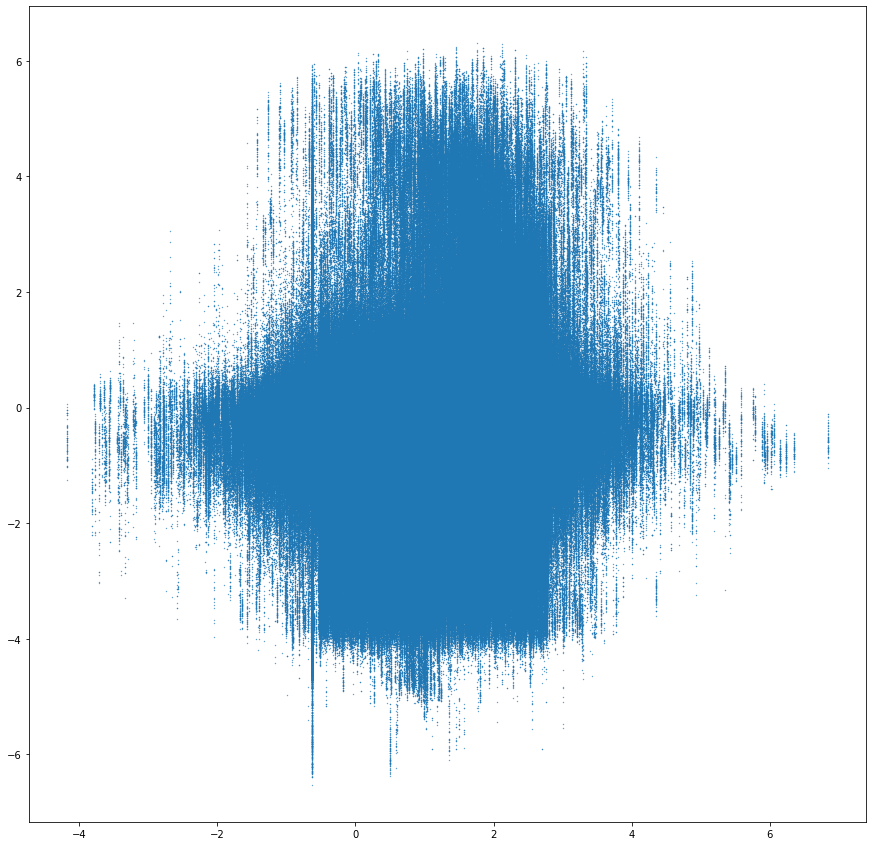

In [17]:
fig = plt.figure(figsize=(15,15))
#plt.plot(xvals, np.multiply(slope,xvals)+intercept)
plt.scatter(x_array,y_array, s=0.1)